In [11]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.distributions import Normal

from models.regression import BayesianRegressor


In [12]:
# Regression Target
def experiment(x, eps):
    return x + 0.3 * torch.sin(2 * torch.pi * (x + eps)) + 0.3 * torch.sin(4 * torch.pi * (x + eps)) + eps
    # return -x**4 + 3*x**2 + 1


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Creating Training Data

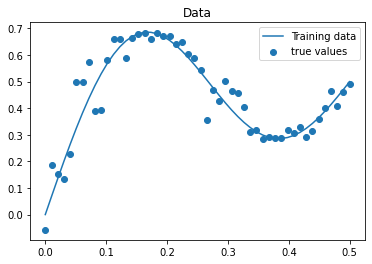

In [14]:
# toy dataset we can start with
train_samples = 50
x_train = torch.linspace(0, 0.5, train_samples).reshape(-1, 1)
eps = Normal(0, 0.02).sample(x_train.size())
y_train = experiment(x_train, eps)
y_train_true = experiment(x_train, 0)

plt.plot(x_train.numpy(), y_train_true.detach().numpy(), label='Training data')
plt.scatter(x_train, y_train, label='true values')
plt.title('Data')
plt.legend()
plt.show()


Defining model and training

In [15]:
model = BayesianRegressor(hidden_dim=128, var_gauss=0.05, mixture_prior=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
elbo_samples = 1
epochs = 2000

x_train = x_train.to(device)
y_train = y_train.to(device)

for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    loss = model.energy_loss(x_train, y_train, elbo_samples)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('epoch: {}/{}'.format(epoch + 1, epochs))
        print('Loss:', loss.item())
print('Finished Training')

epoch: 1/2000
Loss: 8899.8544921875
epoch: 11/2000
Loss: 3623.0458984375
epoch: 21/2000
Loss: 3649.872802734375
epoch: 31/2000
Loss: 3219.422119140625
epoch: 41/2000
Loss: 3187.782958984375
epoch: 51/2000
Loss: 3137.53759765625
epoch: 61/2000
Loss: 3093.301513671875
epoch: 71/2000
Loss: 3023.441650390625
epoch: 81/2000
Loss: 2988.563232421875
epoch: 91/2000
Loss: 2894.738525390625
epoch: 101/2000
Loss: 2873.2646484375
epoch: 111/2000
Loss: 2828.590576171875
epoch: 121/2000
Loss: 2884.189697265625
epoch: 131/2000
Loss: 2760.948974609375
epoch: 141/2000
Loss: 2728.319580078125
epoch: 151/2000
Loss: 2708.73779296875
epoch: 161/2000
Loss: 2709.899658203125
epoch: 171/2000
Loss: 2587.450927734375
epoch: 181/2000
Loss: 2621.35986328125
epoch: 191/2000
Loss: 2592.1376953125
epoch: 201/2000
Loss: 2533.203857421875
epoch: 211/2000
Loss: 2565.954345703125
epoch: 221/2000
Loss: 2487.166015625
epoch: 231/2000
Loss: 2453.89892578125
epoch: 241/2000
Loss: 2505.986328125
epoch: 251/2000
Loss: 2428.88

Prediction

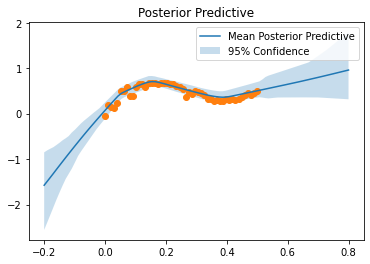

In [16]:
# samples is the number of "predictions" we make for 1 x-value.
test_samples = 100
exp_samples = 100
x_test = torch.linspace(-0.2, 0.8, test_samples).reshape(-1, 1)
y_samp = np.zeros((exp_samples, test_samples))
# Testing experiment
x_test = x_test.to(device)
for s in range(exp_samples):
    y_hat = model.forward(x_test).cpu().detach().numpy()
    y_samp[s, :] = y_hat.reshape(-1)
plt.plot(x_test.cpu().detach().numpy(), np.mean(y_samp, axis=0), label='Mean Posterior Predictive')
plt.fill_between(x_test.cpu().detach().numpy().reshape(-1), np.percentile(y_samp, 2.5, axis=0),
                 np.percentile(y_samp, 97.5, axis=0),
                 alpha=0.25, label='95% Confidence')
plt.legend()
plt.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy())
plt.title('Posterior Predictive')
plt.show()